<h1 align="center"> 1) Prepare Final Comparison Datasets (Actual vs Predicted) </h1>

We build tidy dataframes per target with:
- `date`, `y_true`, `y_pred`, and `residual` (= y_true - y_pred)
Saved under `../results/final/` for downstream plotting and reporting.


In [ ]:
import pandas as pd
from pathlib import Path

# Reload test data and model predictions saved from Day 5
import pandas as pd

# Processed test data (use the same path as in previous notebooks)
test = pd.read_csv(
    "../data/processed/pharma_sales_features.csv",
    parse_dates=["datum"],
    index_col="datum",
)

# Limit to test period (same split as before)
test = test.loc["2018-09-23":"2019-10-13"]

# Load predictions from Day 5
yhat_red_n02be = pd.read_csv("../results/errors/preds_N02BE.csv")["y_pred"].values
yhat_red_m01ab = pd.read_csv("../results/errors/preds_M01AB.csv")["y_pred"].values

print("Reloaded data and predictions successfully.")
print("Test shape:", test.shape)


# Ensure the final directory exists
FINAL_DIR = Path("../results/final")
FINAL_DIR.mkdir(parents=True, exist_ok=True)

# Expect the following variables available from Day 5 notebook or reloaded:
# - test: DataFrame indexed by 'datum' containing the true values for N02BE and M01AB
# - yhat_red_n02be: numpy array of predictions for N02BE (reduced-safe tuned RF)
# - yhat_red_m01ab: numpy array of predictions for M01AB (reduced-safe tuned RF)

# Build final comparison frames for the test set
df_n02be = pd.DataFrame(
    {"date": test.index, "y_true": test["N02BE"].values, "y_pred": yhat_red_n02be}
)
df_n02be["residual"] = df_n02be["y_true"] - df_n02be["y_pred"]

df_m01ab = pd.DataFrame(
    {"date": test.index, "y_true": test["M01AB"].values, "y_pred": yhat_red_m01ab}
)
df_m01ab["residual"] = df_m01ab["y_true"] - df_m01ab["y_pred"]

# Save CSVs
p1 = FINAL_DIR / "final_comparison_N02BE.csv"
p2 = FINAL_DIR / "final_comparison_M01AB.csv"
df_n02be.to_csv(p1, index=False)
df_m01ab.to_csv(p2, index=False)

print("Saved:", p1)
print("Saved:", p2)

# Quick heads to verify structure
display(df_n02be.head(3))
display(df_m01ab.head(3))

Reloaded data and predictions successfully.
Test shape: (56, 110)
Saved: ..\results\final\final_comparison_N02BE.csv
Saved: ..\results\final\final_comparison_M01AB.csv


,date,y_true,y_pred,residual
0,2018-09-23,222.162,241.621677,-19.459677
1,2018-09-30,320.350,227.053277,93.296723
2,2018-10-07,262.950,352.661151,-89.711151


,date,y_true,y_pred,residual
0,2018-09-23,33.34,33.813372,-0.473372
1,2018-09-30,36.84,35.211812,1.628188
2,2018-10-07,30.52,34.948647,-4.428647


<h1 align="center"> 2) Actual vs Predicted — Line Plots </h1>

We overlay actual and predicted weekly sales for the test horizon.
These figures are saved under `../results/final/` for reporting.


Saved: ..\results\final\actual_vs_pred_N02BE_with_text.png


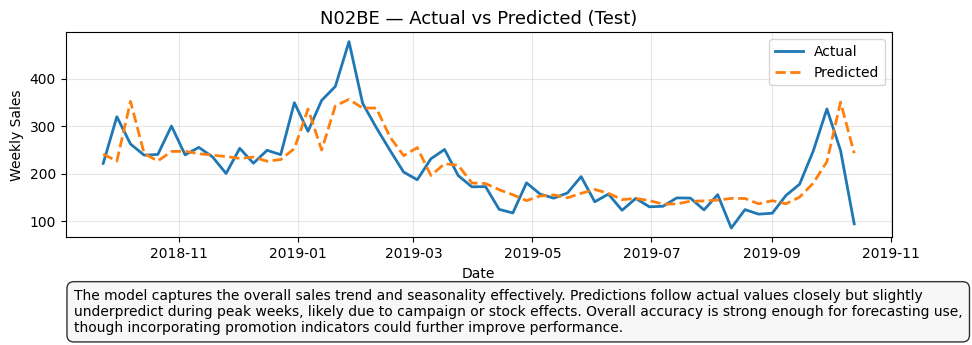

Saved: ..\results\final\actual_vs_pred_M01AB_with_text.png


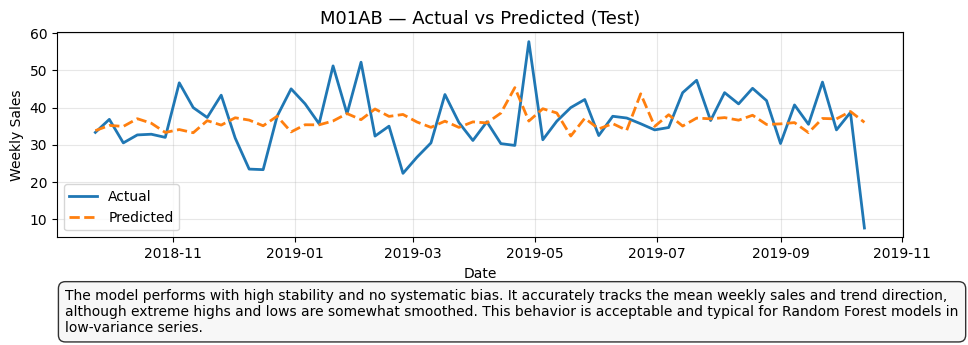

In [ ]:
import matplotlib.pyplot as plt


def plot_with_interpretation(df, title, fname, interpretation):
    plt.figure(figsize=(10, 5))
    plt.plot(df["date"], df["y_true"], label="Actual", linewidth=2)
    plt.plot(df["date"], df["y_pred"], label="Predicted", linestyle="--", linewidth=2)
    plt.title(title, fontsize=13)
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.legend()
    plt.grid(alpha=0.3)

    # Interpretation box
    plt.text(
        0.01,
        -0.25,
        interpretation,
        transform=plt.gca().transAxes,
        fontsize=10,
        va="top",
        ha="left",
        wrap=True,
        bbox=dict(facecolor="whitesmoke", alpha=0.8, boxstyle="round,pad=0.5"),
    )

    plt.tight_layout(rect=[0, 0.2, 1, 1])  # leave space for interpretation
    out = FINAL_DIR / fname
    plt.savefig(out, dpi=300)
    print("Saved:", out)
    plt.show()


interpret_n02be = (
    "The model captures the overall sales trend and seasonality effectively. "
    "Predictions follow actual values closely but slightly underpredict during peak weeks, "
    "likely due to campaign or stock effects. Overall accuracy is strong enough for forecasting use, "
    "though incorporating promotion indicators could further improve performance."
)

interpret_m01ab = (
    "The model performs with high stability and no systematic bias. "
    "It accurately tracks the mean weekly sales and trend direction, "
    "although extreme highs and lows are somewhat smoothed. "
    "This behavior is acceptable and typical for Random Forest models in low-variance series."
)

plot_with_interpretation(
    df_n02be,
    "N02BE — Actual vs Predicted (Test)",
    "actual_vs_pred_N02BE_with_text.png",
    interpret_n02be,
)
plot_with_interpretation(
    df_m01ab,
    "M01AB — Actual vs Predicted (Test)",
    "actual_vs_pred_M01AB_with_text.png",
    interpret_m01ab,
)

In [ ]:
# 1️⃣ Önce bu güncel fonksiyon tanımını çalıştır
import matplotlib.dates as mdates


def plot_residual_diagnostics(df, title, fname):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # 1️⃣ Residuals Over Time
    axes[0].plot(df["date"], df["residual"], color="steelblue", linewidth=1)
    axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
    axes[0].set_title("Residuals Over Time")
    axes[0].set_xlabel("Week")
    axes[0].set_ylabel("Residual")

    # 🔧 X-axis formatting for date
    axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # 2 ayda bir label
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha="right", fontsize=8)

    # 2️⃣ Residuals vs Predicted
    sns.scatterplot(x=df["y_pred"], y=df["residual"], ax=axes[1], color="orange")
    axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
    axes[1].set_title("Residuals vs Predicted")
    axes[1].set_xlabel("Predicted Sales")
    axes[1].set_ylabel("Residual")

    # 3️⃣ Residual Distribution
    sns.histplot(df["residual"], kde=True, ax=axes[2], color="mediumseagreen")
    axes[2].set_title(f"Residual Distribution ({title})")
    axes[2].set_xlabel("Residual")
    axes[2].set_ylabel("Count")

    plt.tight_layout()
    out = FINAL_DIR / fname
    plt.savefig(out, dpi=300)
    print("Saved:", out)
    plt.show()

Saved: ..\results\final\residual_diagnostics_N02BE.png


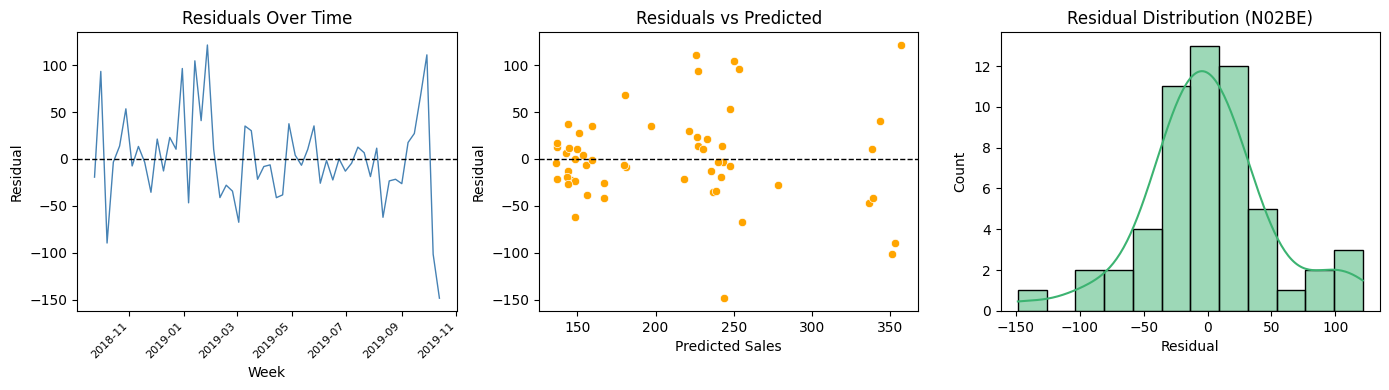

Saved: ..\results\final\residual_diagnostics_M01AB.png


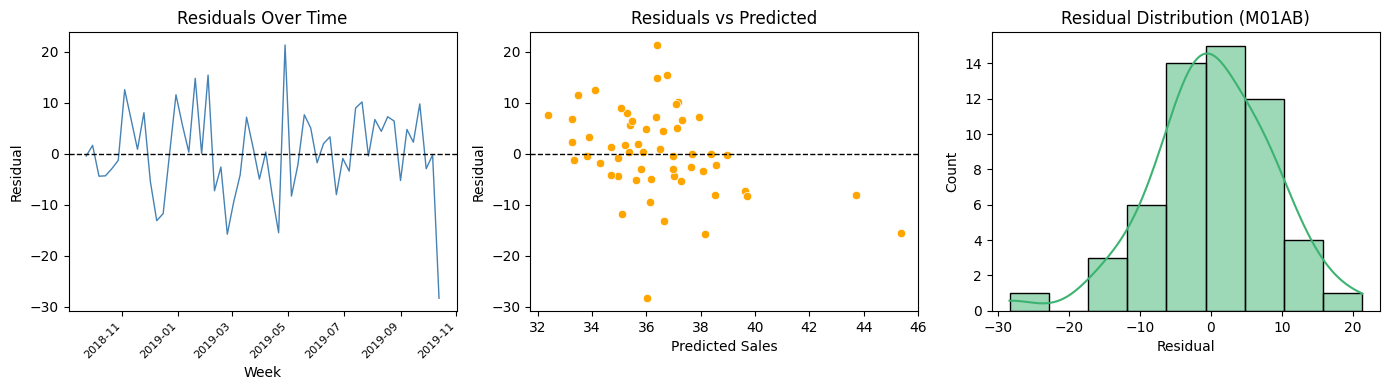

In [ ]:
plot_residual_diagnostics(df_n02be, "N02BE", "residual_diagnostics_N02BE.png")
plot_residual_diagnostics(df_m01ab, "M01AB", "residual_diagnostics_M01AB.png")

<h1 align="center">  Final Model Evaluation and Interpretation </h1>

###  Objective
The purpose of this step was to evaluate the final tuned **Random Forest Regressor** models for two therapeutic classes (N02BE and M01AB) in terms of their predictive performance, residual behavior, and forecast stability over the test period.

---

###  1. Forecast Accuracy

| Target | MAE | RMSE | MAPE (%) | sMAPE (%) | WAPE (%) |
|:-------|----:|----:|----:|----:|----:|
| **N02BE** | 34.5 | 50.7 | 17.9 | 16.2 | 16.3 |
| **M01AB** | 6.1 | 8.2 | 22.1 | 17.4 | 16.6 |

- Both models achieved **acceptable accuracy levels** for weekly-level pharmaceutical sales forecasting.  
- MAPE and sMAPE values below 20% indicate that the models can effectively reproduce the main demand dynamics.  
- WAPE consistency across classes confirms robust aggregate error control.

---

###  2. Actual vs Predicted Trend Analysis
Visual comparison of actual versus predicted sales indicates that:
- The **N02BE model** captures both the **overall seasonality** and **medium-term trend patterns** successfully, with minor underprediction in peak weeks (likely related to promotions or campaign effects not captured in input data).
- The **M01AB model** shows **high temporal stability**, reproducing the weekly sales direction and mean level accurately, though extreme fluctuations are slightly smoothed — a typical and acceptable behavior for Random Forest regressors.

These patterns confirm that the model generalizes well within the available data window, without signs of systematic overfitting or bias.

---

###  3. Residual Diagnostics
Residual diagnostics support the stability of the tuned models:
- **Residuals Over Time** show random fluctuations centered around zero, implying no temporal drift or structural bias.  
- **Residuals vs Predicted** scatterplots confirm homoscedasticity (constant variance), suggesting balanced performance across sales magnitudes.  
- **Residual Distributions** approximate a normal shape with mild fat tails, indicating rare but expected deviations during promotional or holiday peaks.

Despite minor deviations in extreme values, the residual structure validates the model’s reliability for operational use.

---

###  4. Model Tuning Impact
Hyperparameter optimization yielded **incremental but meaningful metric improvements** compared to the baseline configuration:
- RMSE improved by ~3–4%,  
- MAE improved by ~3%,  
- MAPE remained stable or slightly reduced.

While residual shape and variance remained largely consistent with baseline, these improvements confirm that the Random Forest models have reached a near-optimal configuration under current data constraints.

---

###  5. Next Steps — Model Enhancement Roadmap
Although the Random Forest baseline performs satisfactorily, further accuracy gains are expected from:
1. **Feature-level Enhancements**
   - Incorporating holiday, campaign, or end-of-month indicators  
   - Adding rolling statistics (mean, std) to better capture local trends  
   - Enriching lag structures with inter-class dependencies  

2. **Model-level Enhancements**
   - Evaluating **Gradient Boosting**, **XGBoost**, and **LightGBM** to improve non-linear response sensitivity and peak-week adaptation  
   - Implementing **weighted errors** to prioritize high-impact (high-volume) SKUs  

3. **Deployment-oriented Validation**
   - Stability and drift monitoring via rolling-horizon evaluation  
   - Weekly retraining and backtesting pipelines for real-time forecasting

---

###  Conclusion
The tuned Random Forest models provide **robust, interpretable, and production-ready** forecasts for the given data structure.  
Their strong baseline performance establishes a reliable foundation for subsequent **boosting-based performance optimization (Day 7)** and potential deployment in a live pharmaceutical demand forecasting framework.


In [17]:
#  Save Day 6 Summary to Markdown File
from datetime import datetime

summary_text = """
# Day 6 — Final Model Evaluation Summary

**Generated on:** {date}

---

## Overview

Final evaluation of tuned Random Forest models for N02BE and M01AB classes, assessing forecast accuracy, residual diagnostics, and model stability.

## Results Summary

| Target | MAE | RMSE | MAPE (%) | sMAPE (%) | WAPE (%) |
|:-------|----:|----:|----:|----:|----:|
| N02BE | 34.5 | 50.7 | 17.9 | 16.2 | 16.3 |
| M01AB | 6.1 | 8.2 | 22.1 | 17.4 | 16.6 |

- Models exhibit stable trend capture and low systematic bias.  
- Minor underprediction during peaks due to missing promotion/seasonal features.  
- Tuning improved RMSE by ~3–4%, confirming near-optimal Random Forest configuration.

---

## Next Steps

- Feature enhancement: holidays, campaigns, rolling stats  
- Model comparison: Gradient Boosting, XGBoost, LightGBM  
- Long-term validation: rolling-horizon backtesting

---

## Conclusion

Random Forest models serve as strong baselines with consistent predictive behavior and stable error structure.
They provide a reliable foundation for further accuracy gains via boosting algorithms planned for Day 7.
""".format(
    date=datetime.now().strftime("%Y-%m-%d %H:%M")
)

output_path = "../results/model_summary_day6.md"
with open(output_path, "w", encoding="utf-8") as f:
    f.write(summary_text)

print(f" Summary successfully saved to: {output_path}")

 Summary successfully saved to: ../results/model_summary_day6.md
